## Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import sys
sys.path.insert(0, '/home/ravi/Desktop/eelfff')

In [4]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## DQN architecture

In [5]:
torch.cuda.is_available()

True

In [6]:
dtype = torch.cuda.FloatTensor

In [7]:
class eelfff(nn.Module):
    
    def __init__(self, img_dim=8):
        super(eelfff, self).__init__()
        self.img_dim = img_dim
        
        # inputs: image + rot vec + id compare + pos-other_pos
        self.net = nn.Sequential(
                                nn.Linear(self.img_dim**2 + 2 + 1 + 2, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 9)
                            )

    def forward(self, feat):
        return self.net(feat)


test network with random data

In [8]:
tic = time.clock()
N = 4
img_dim = 3

model = eelfff(img_dim).type(dtype)
feat = Variable(torch.randn(N,img_dim**2+2+1+2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([4, 9])
321.04s = 5.35m elapsed for this test


## load the network

In [9]:
img_dim = 3
model = eelfff(img_dim=img_dim).type(dtype)

In [10]:
# optionally load a checkpoint to resume training
filename = '/home/ravi/Desktop/eelfff/networks/simple_ext-26-Aug-2017-15:17.pth.tar'

checkpoint = torch.load(filename)
model.load_state_dict(checkpoint['state_dict'])

## Benchmark network solution 

In [11]:
results = []

In [12]:
grid_size = 50
num_agents = 100

x = math.ceil(grid_size / 2)
deltas = [q for q in range(-5,5,1)]
neighbors = itertools.product(deltas,deltas)
fire_init = []
for (dx,dy) in neighbors:
    xn = x + dx
    yn = x + dy
    fire_init.append((xn,yn))

dp = 0.15/0.2763
repeat_lim = 6
center = (grid_size+1)/2
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

seeds = [1000]

In [13]:
tic = time.clock()
for i,s in enumerate(seeds):
    np.random.seed(1000+s)

    # initialize simulator
    sim = FireSimulator(grid_size, rng=s, fire_init=fire_init)
    #sim = FireSimulator(grid_size, rng=s)
    #sim.step([]) # start fire in domain
    
    num_init_fires = len(sim.fires)

    # initialize agent position
    n = num_agents
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = np.squeeze(agent_pos).astype(np.int32)
    agent_data = {}
    for k in range(n):
        agent_data[k] = {}
        agent_data[k]['sf'] = False

    control = []
    repeat_ctr = 1

    new_agent_pos = np.zeros((n,2)).astype(np.int32)

    while not sim.end:
        # calculate action for each agent
        for k in range(n):
            img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            if img_st[8//2,8//2] in [1,2]:
                agent_data[k]['sf'] = True                

            dists = [(np.linalg.norm(agent_pos[k,:]-p,2),j,p) for j,p in enumerate(agent_pos) if j!=k]
            min_dist, min_id, min_pos = min(dists)                
                
            if not agent_data[k]['sf']:
                
                dists = []
                for idx,a in enumerate([2,5,7,4,1,3,8,6]):
                    new_pos = actions_to_trajectory(agent_pos[k,:],[a])[1]
                    incntv = -(8-idx)*0.1
                    dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))

                score, pos, action = min(dists)
                traj = actions_to_trajectory(agent_pos[k,:], [action])

            else:
                rot_vec = agent_pos[k,:] - center
                rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
                rot_vec = np.array([rot_vec[1],-rot_vec[0]])

                pos_vec = agent_pos[k,:] - min_pos
                if pos_vec[0]!=0 and pos_vec[1]!= 0:
                    pos_vec = pos_vec / np.linalg.norm(pos_vec,2)

                state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec, 
                                        np.asarray(k>min_id)[np.newaxis], pos_vec))
            
                state = Variable(torch.from_numpy(state)).type(dtype)
                Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
                action = np.argmax(Q)
                traj = actions_to_trajectory(agent_pos[k,:], [action])

            # generate control from trajectory
            control.extend(FindGridIntersections(sim.state, traj)) 
            control = list(set(control))

            # update agent location
            new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]

        # update simulator periodically 
        if repeat_ctr % repeat_lim == 0:
            sim.step(control, dbeta=dp)
            control = []
        repeat_ctr += 1

        # update agent position
        agent_pos = new_agent_pos
        new_agent_pos = np.zeros((n,2)).astype(np.int32)

    if (i+1) % 10 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

69.50s = 1.16m elapsed


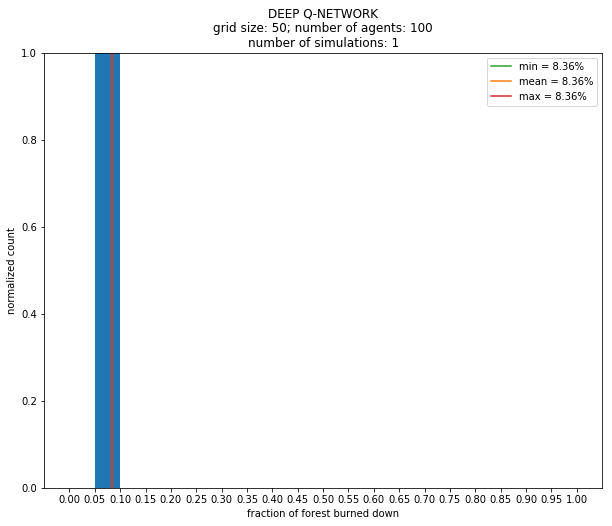

In [14]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('DEEP Q-NETWORK\ngrid size: %d; number of agents: %d\nnumber of simulations: %d' %(grid_size,n,len(results)))
plt.legend(loc=1)

# plt.savefig('network_guided (110-1000).png', bbox_inches='tight')

In [28]:
splits

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [29]:
np.mean(results)

0.98440000000000005

In [ ]:
with open('simple_ext_%d+%d+%d+%d.pkl' %(grid_size,num_agents,num_init_fires,len(seeds)), 'wb') as fp:
    pickle.dump(results, fp)

In [26]:
win_results = [x for x in results if x <= np.mean(results)]
print('fraction of wins: %0.2f' % (100.0*len(win_results)/len(results)))
print('win mean: %0.2f' %(np.mean(win_results)*100))

fraction of wins: 100.00
win mean: 1.60
